In [1]:
import sys
sys.path.append("src") # add the source dir

In [2]:

%matplotlib qt
import mne
import numpy as np
import matplotlib.pyplot as plt
import os
from src.pipeline import Pipeline
from mne_bids import BIDSPath

## Generate three random subjects for cleaning and preprocessing

In [3]:
import random
random.seed(1334)
subjects = [random.randrange(1, 40, 1) for i in range(3)]
print("We will be doing cleaning and processing for subjects {}".format(subjects))
bids_root = os.path.join('data', 'P3')
bids_paths = [ BIDSPath(subject=str(sub).zfill(3), session='P3', task='P3',
                        datatype='eeg', suffix='eeg', root=bids_root) for sub in subjects]

We will be doing cleaning and processing for subjects [30, 5, 2]


### Load data for above subjects

In [4]:
pipelines = [ Pipeline(path).load_data() for path in bids_paths]
raw_30, raw_5, raw_2 = [pipeline.raw for pipeline in pipelines]

INFO:root:Loading Data
INFO:root:Loading Data
INFO:root:Loading Data


### Displaying general Information about the data

In [5]:
n_time_samps = raw_30.n_times
time_secs = raw_30.times
ch_names = raw_30.ch_names
n_chan = len(ch_names)
print('the raw data for subject {} has {} time samples and {} channels.'
      ''.format(pipelines[0].subject, n_time_samps, n_chan))
print('The last time sample is at {} seconds.'.format(time_secs[-1]))
print('The first few channel names are {}....'.format(', '.join(ch_names[:5])))
print('sample rate:', raw_30.info['sfreq'], 'Hz')
print('%s channels x %s samples' % (len(raw_30), len(raw_30.times)))
print("The channel names are {}".format(ch_names))

the raw data for subject 030 has 393216 time samples and 33 channels.
The last time sample is at 383.9990234375 seconds.
The first few channel names are FP1, F3, F7, FC3, C3....
sample rate: 1024.0 Hz
393216 channels x 393216 samples
The channel names are ['FP1', 'F3', 'F7', 'FC3', 'C3', 'C5', 'P3', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Oz', 'Pz', 'CPz', 'FP2', 'Fz', 'F4', 'F8', 'FC4', 'FCz', 'Cz', 'C4', 'C6', 'P4', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'HEOG_left', 'HEOG_right', 'VEOG_lower']


### Plotting the EEG data for Pz channel

In [6]:
eeg_channel_indices = mne.pick_channels(raw_30.ch_names, ['Cz'])
start_stop_seconds = np.array([10, 50])
start_sample, stop_sample = raw_30.time_as_index(start_stop_seconds) #(start_stop_seconds * sfreq).astype(int)
eeg_data, times = raw_30[eeg_channel_indices, start_sample:stop_sample]

import seaborn as sns
sns.lineplot(times, eeg_data.T.reshape(-1));

### Display Montage settings

In [7]:
montage_dir = os.path.join(os.path.dirname(mne.__file__),
                           'channels', 'data', 'montages')
print('\nBUILT-IN MONTAGE FILES')
print('======================')
print(sorted(os.listdir(montage_dir)))


BUILT-IN MONTAGE FILES
['EGI_256.csd', 'GSN-HydroCel-128.sfp', 'GSN-HydroCel-129.sfp', 'GSN-HydroCel-256.sfp', 'GSN-HydroCel-257.sfp', 'GSN-HydroCel-32.sfp', 'GSN-HydroCel-64_1.0.sfp', 'GSN-HydroCel-65_1.0.sfp', 'artinis-brite23.elc', 'artinis-octamon.elc', 'biosemi128.txt', 'biosemi16.txt', 'biosemi160.txt', 'biosemi256.txt', 'biosemi32.txt', 'biosemi64.txt', 'easycap-M1.txt', 'easycap-M10.txt', 'mgh60.elc', 'mgh70.elc', 'standard_1005.elc', 'standard_1020.elc', 'standard_alphabetic.elc', 'standard_postfixed.elc', 'standard_prefixed.elc', 'standard_primed.elc']


In [8]:
for pipeline in pipelines: pipeline.set_montage() 
fig = plt.figure()
ax2d = fig.add_subplot(121)
ax3d = fig.add_subplot(122, projection='3d')
raw_30.plot_sensors(ch_type='eeg', axes=ax2d, show_names=False); #showing names makes it clumsy
raw_30.plot_sensors(ch_type='eeg', axes=ax3d, kind='3d');
ax3d.view_init(azim=70, elev=15);

INFO:root:Standard 1020 montage and EOG channels are set
INFO:root:Standard 1020 montage and EOG channels are set
INFO:root:Standard 1020 montage and EOG channels are set


## Finding bad channels and segments

# Filtering

### Since, deciding filter setting will be same for all three subjects, we will discuss the need by taking into consideration only one subject, we can remove slow drifts and power line noises from our data

### Low-frequency drifts in raw data can usually be spotted by plotting a fairly long span of data with the plot() method, though it is helpful to disable channel-wise DC shift correction to make slow drifts more readily visible. Here we plot 60 seconds, showing all the channels:

In [9]:
raw_30.plot(duration=70, proj=False, remove_dc=False);
# raw_2.plot(duration=70, proj=False, remove_dc=False);
# raw_5.plot(duration=70, proj=False, remove_dc=False);

![filtering](images/filtering.jpg)


### There seems to be very small drifts in the data, and half-period of this slow drift appears to last around 5 seconds, so a full period would be less than 10 seconds. $( < \frac{1}{10}Hz )$, To exclude those components, we would want a highpass filter which is higher or equal to $ \frac{1}{10}Hz $, i.e $( \frac{1}{5}Hz )$ or  $ ( \frac{1}{10}Hz )$

### Power line noise is an environmental artifact that manifests as persistent oscillations centered around the AC power line frequency

In [10]:
raw_30.plot_psd(fmax=250, average=True);

![power line](images/power_line.jpg)

### It appears that we have a line noise artifact at around 60Hz. To remove this we will use the low-pass filter at 50HZ. Frequency-domain construction is good when an arbitrary response is desired, but generally less clean (due to sampling issues) than a windowed approach for more straightforward filter applications. Since our filters (low-pass, high-pass, band-pass, band-stop) are fairly simple and we require precise control of all frequency regions, we will primarily use and explore windowed FIR design. Furthermore we will use `firwin` and not `firwin2` because  `firwin` uses a time-domain design technique that generally gives improved attenuation using fewer samples than `firwin2`.

In [11]:
raw_30.filter(l_freq=None, h_freq=50, fir_design='firwin')
raw_2.filter(l_freq=None, h_freq=50, fir_design='firwin')
raw_5.filter(l_freq=None, h_freq=50, fir_design='firwin')

<RawEEGLAB | sub-005_ses-P3_task-P3_eeg.fdt, 33 x 391168 (382.0 s), ~98.5 MB, data loaded>

# Finding Eye blinks artifacts

In [12]:
raw_30

<RawEEGLAB | sub-030_ses-P3_task-P3_eeg.fdt, 33 x 393216 (384.0 s), ~99.0 MB, data loaded>

### We will use the `find_eog_events` to find eye blinks events and We’ll start the annotations 250 ms before the blink and end them 250 ms after it

In [13]:
def set_eye_blink_annotations(raw: mne.io.Raw):
    eog_events = mne.preprocessing.find_eog_events(raw)
    onsets = eog_events[:, 0] / raw.info['sfreq'] - 0.25
    durations = [0.5] * len(eog_events)
    descriptions = ['bad blink'] * len(eog_events)
    blink_annot = mne.Annotations(onsets, durations, descriptions, orig_time=raw.info['meas_date'])
    raw.set_annotations(raw.annotations + blink_annot)
    return eog_events

In [14]:
eog_events_30 = set_eye_blink_annotations(raw_30)
eog_events_2 = set_eye_blink_annotations(raw_2)
eog_events_5 = set_eye_blink_annotations(raw_5)

In [15]:
eeg_picks = mne.pick_types(raw_30.info, eeg=True)
raw_30.plot(events=eog_events_30, order=eeg_picks);

### Below is the bad blinks artifacts for subject 30 found using mne

![bad blinks](images/bad_blinks_30.jpg)

In [16]:
eeg_picks = mne.pick_types(raw_2.info, eeg=True)
raw_2.plot(events=eog_events_2, order=eeg_picks);

### Though it appears that it is not very reliable? For example, in the figure below the blink annotation should have been at location 323 seconds

![bad blinks](images/bad_blinks_2.jpg)

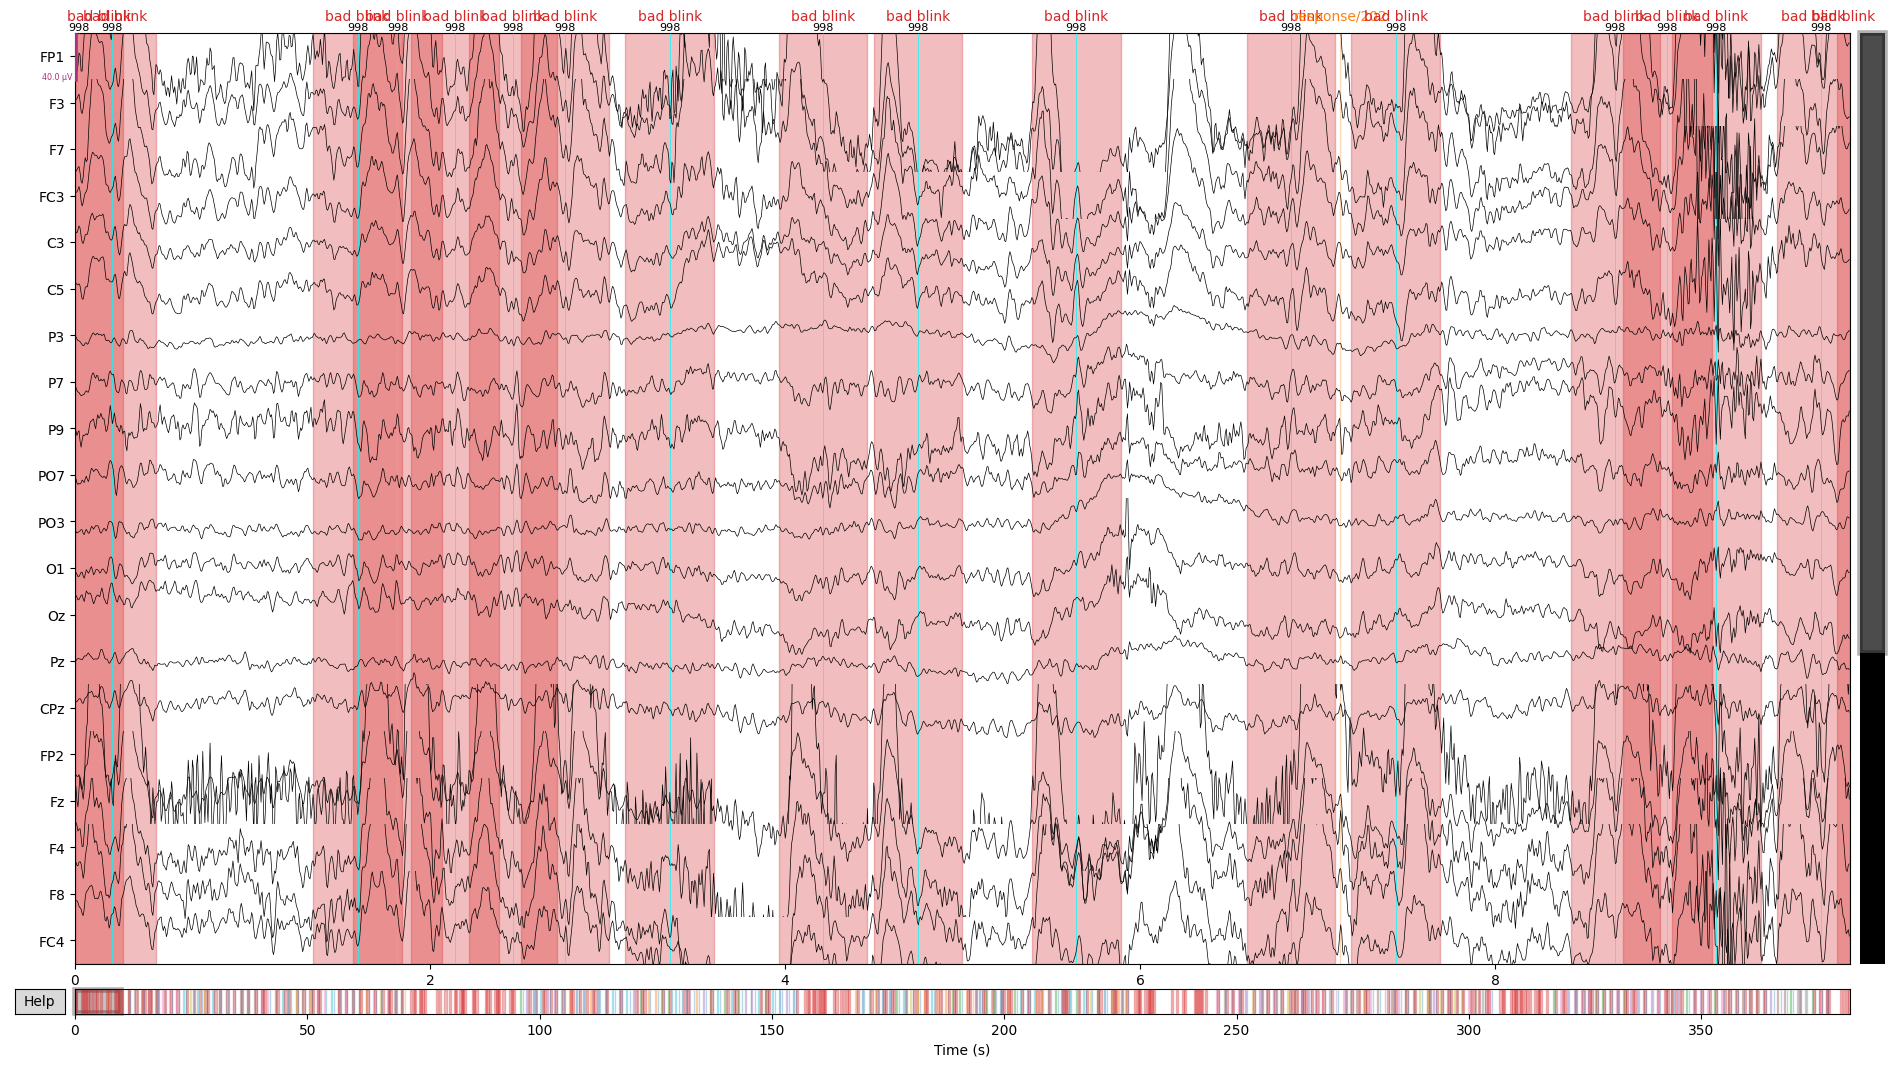

In [20]:
eeg_picks = mne.pick_types(raw_5.info, eeg=True)
raw_5.plot(events=eog_events_5, order=eeg_picks)

### Looks like subject 5 has too many blink events!!
Going through the raw data using plot it seems like it is giving the correct result

### ICA

In [18]:
ica = mne.preprocessing.ICA(method="fastica")
ica.fit(raw,decim=3, verbose=True)
eog_indices, eog_scores = ica.find_bads_eog(raw)
ica.exclude = eog_indices

# barplot of ICA component "EOG match" scores
ica.plot_scores(eog_scores, exclude=eog_indices)

NameError: name 'raw' is not defined

In [ ]:
ica.plot_sources(raw, show_scrollbars=False)

In [ ]:
mne.viz.plot_events(events, event_id=event_id, sfreq=raw.info['sfreq']);

In [ ]:
eog_evoked = mne.preprocessing.create_eog_epochs(raw).average()
eog_evoked.apply_baseline(baseline=(None, -0.2))
eog_evoked.plot_joint()
# plot ICs applied to the averaged EOG epochs, with EOG matches highlighted
ica.plot_sources(eog_evoked)

In [ ]:
ica.exclude = []
# find which ICs match the EOG pattern
eog_indices, eog_scores = ica.find_bads_eog(raw)
ica.exclude = eog_indices

# barplot of ICA component "EOG match" scores
ica.plot_scores(eog_scores)

# plot diagnostics
# ica.plot_properties(raw, picks=eog_indices)

# plot ICs applied to raw data, with EOG matches highlighted
ica.plot_sources(raw, show_scrollbars=True)


# ica.plot_overlay(raw, exclude=eog_indices, picks='eeg')

In [ ]:
eog_epochs = mne.preprocessing.create_eog_epochs(raw)  # get single EOG trials
eog_inds, scores = ica.find_bads_eog(eog_epochs)  # find via correlation

ica.plot_scores(scores, exclude=eog_inds);  # look at r scores of components

In [ ]:
from time import time
def run_ica(method, fit_params=None):
    ica = mne.preprocessing.ICA(n_components=20, method=method, fit_params=fit_params,
              max_iter='auto', random_state=35)
    t0 = time()
    ica.fit(nraw)
    fit_time = time() - t0
    title = ('ICA decomposition using %s (took %.1fs)' % (method, fit_time))
    ica.plot_components(title=title)

In [ ]:
run_ica('fastica')

In [ ]:
run_ica('picard')

In [ ]:
run_ica('infomax')

In [ ]:
raw.plot_psd(average=True)

### EPOCHING

In [ ]:
epochs = mne.Epochs(raw, events, event_id, tmin=-0.1, tmax=1,
                    baseline=(None, 0), preload=True)
print(epochs)

In [ ]:
print(epochs.events[:3])
print(epochs.event_id)

In [ ]:
print(epochs[1:5])
print(epochs['stimulus/11'])
print(epochs['stimulus/21'])
print(epochs['stimulus/31'])
print(epochs['response'])

In [ ]:
epochs.plot_drop_log();

In [ ]:
# epochs.plot(block=True, events=events);

In [ ]:
epochs.plot_image(12, cmap='interactive', sigma=1., vmin=-400, vmax=400);

In [ ]:
stim_events = dict((k, event_id[k]) for k in event_id.keys() if "stimulus" in k)
epochs = mne.Epochs(raw, events, stim_events, tmin=-0.2, tmax=0.8, picks=['Pz'])


# Average epochs for faces and car
rare_stim = set(range(11, 55+1, 11))
freq_stim = set(range(11, 55+1)) - set(range(11, 55+1, 11))

evoked_a = epochs[["stimulus/{}".format(f) for f in rare_stim]].average()
evoked_b = epochs[["stimulus/{}".format(f) for f in freq_stim]].average()

# Plot evokeds
mne.viz.plot_compare_evokeds({"Target A": evoked_a, "Target B": evoked_b}, show=False, title="ERPs before ICA", combine="mean")

In [ ]:
rare_stim